In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.cluster import AgglomerativeClustering    

import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import random
np.random.seed(0)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA

def plot3d(X, labels):
    %matplotlib notebook
    from mpl_toolkits.mplot3d import Axes3D
    
    # Check the shape of X and labels before proceeding
    print(f"Shape of X before reshaping: {X.shape}")
    print(f"Number of labels: {len(labels)}")
    
    # Ensure X is reshaped correctly
    X = X.reshape(X.shape[0], -1)
    print(f"Shape of X after reshaping: {X.shape}")
    
    # Reduce features dimensionality for visualization purposes
    pca = PCA(n_components=3)
    X = pca.fit_transform(X)
    print(f"Shape of X after PCA: {X.shape}")
    
    # Convert string labels to numeric labels
    unique_labels = np.unique(labels)
    label_to_num = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_to_num[label] for label in labels])
    
    print(f"Unique labels: {unique_labels}")
    print(f"Numeric labels: {numeric_labels}")
    
    nlabels = len(unique_labels)
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define color mappings
    col = ('tab10' if nlabels <= 10 else 
           ('tab20' if nlabels <= 20 else
            'hsv'))
    cmap = plt.cm.get_cmap(col)
    
    # Plot the 3D coordinates
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=numeric_labels, cmap=cmap)
    
    # Create a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(label_to_num[label] / (nlabels - 1)), markersize=10) for label in unique_labels]
    ax.legend(handles, unique_labels, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()


# Clustering

## K-means

In [12]:
def get_Ncounts(y_predict, y_true, k, j=None):
    #N is the total number of samples
    N = X.shape[0]
    #Nk is the total number of samples in cluster k
    Nk_mask = y_predict==k
    Nk = Nk_mask.sum()
    Nj, Nkj = None, None
    #if we have a label
    if j is not None:
        Nj_mask = y_true==j
        Nj = Nj_mask.sum()
        #samples that are both in cluster k and with label j
        Nkj = np.logical_and(Nk_mask, Nj_mask).sum()
    return N, Nk, Nj, Nkj

##computing precision
def precision(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nk + 1e-8)

#computing recall
def recall(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nj + 1e-8)

#computing F1
def F(y_predict, y_true, k, j):
    p = precision(y_predict, y_true, k, j)
    r = recall(y_predict, y_true, k, j)
    return (2*p*r) / (p+r)

#computing purity
def purity(y_predict, y_true, k):
    cls = np.unique(y_true)
    prec = [precision(y_predict, y_true, k, j) for j in cls]
    return max(prec)

def tot_purity(y_predict, y_true):
    N = y_true.shape[0]
    nc = len(np.unique(y_true))
    p = 0
    for k in range(nc):
        N, Nk, _, _ = get_Ncounts(y_predict, y_true, k)
        pk = purity(y_predict, y_true, k)
        p += (Nk / N) * pk
    return p

Kmeans purity 0.5758971406571254
Shape of X before reshaping: (10422, 63)
Number of labels: 10422
Shape of X after reshaping: (10422, 63)
Shape of X after PCA: (10422, 3)
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10]
Numeric labels: [ 6  2 10 ...  5  3  3]


<IPython.core.display.Javascript object>


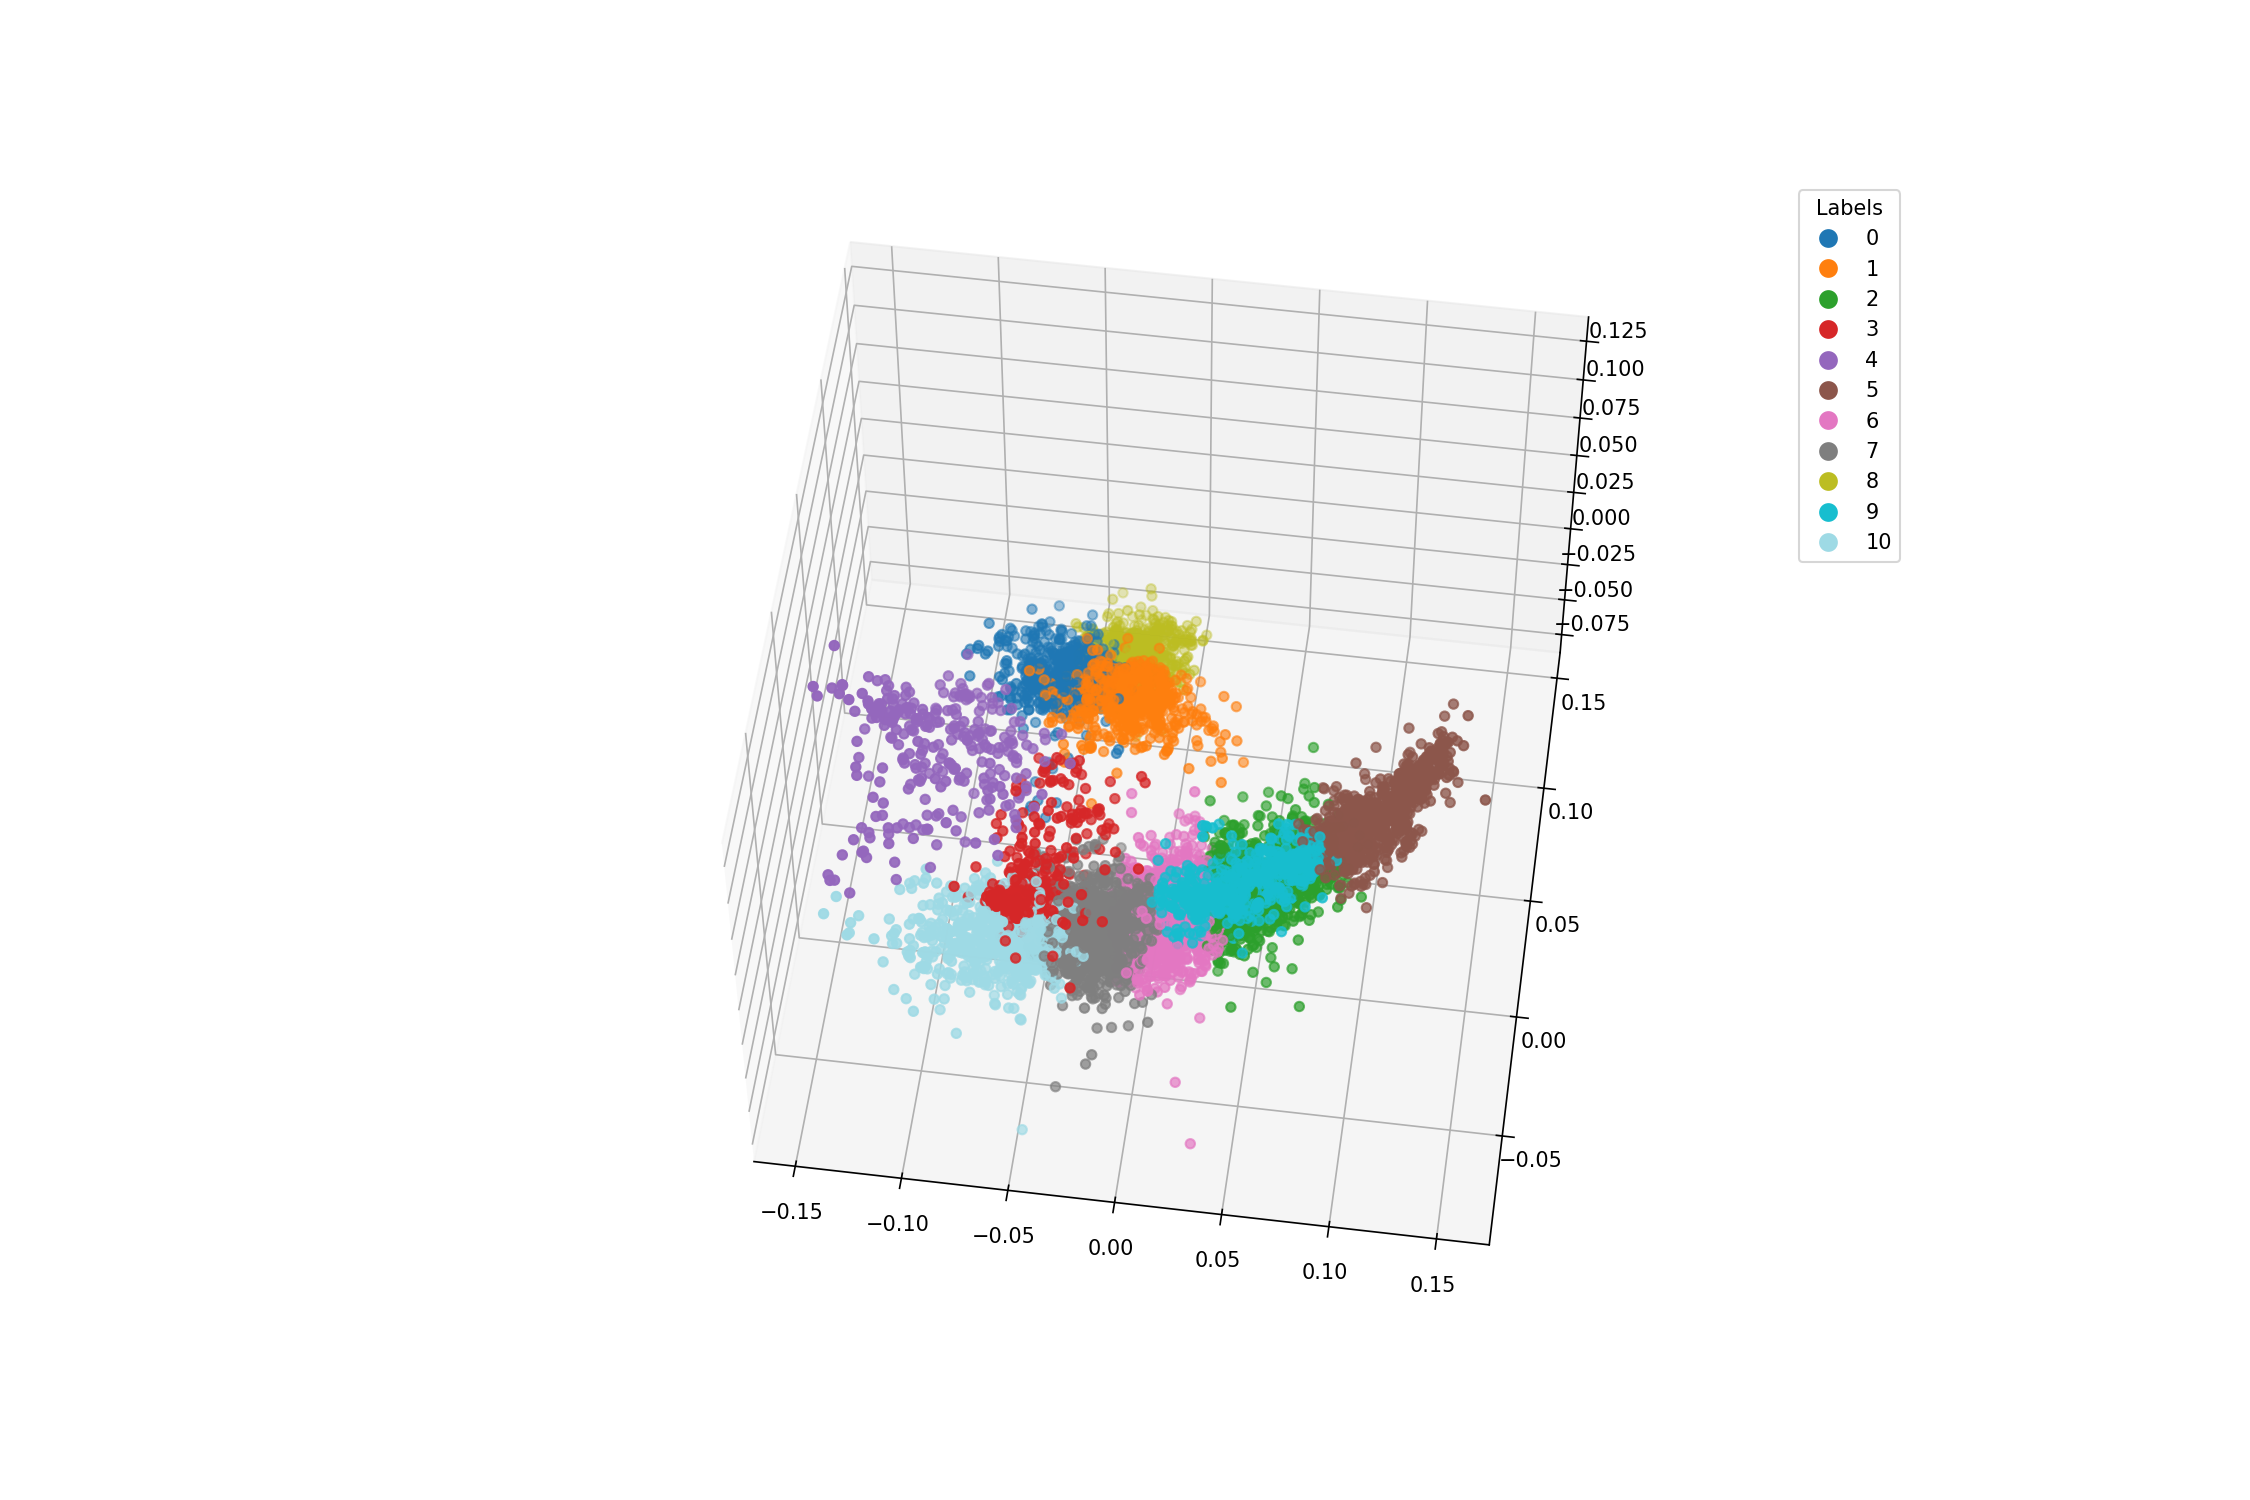

C:\Users\comin\AppData\Local\Temp\ipykernel_24640\457259440.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(col)


In [30]:
from sklearn.cluster import KMeans

X = training.iloc[:, 5:].drop("AGA", axis=1).to_numpy()
y = training.loc[:, "Kingdom"]

model = KMeans(n_clusters=11, init='random', random_state=0, n_init=10)             
y_predict = model.fit_predict(X)
print("Kmeans purity", tot_purity(y_predict, y))

plot3d(X, labels=y_predict)

### Comparing the performance of the different strategies to initialize the K-means algorithm

In [24]:
# Random initialization
model = KMeans(n_clusters=11, init='random', random_state=0, n_init=10)             
print("Random Kmeans purity: ", tot_purity(model.fit_predict(X), y))

# K-Means++
model = KMeans(n_clusters=11, init='k-means++', random_state=0, n_init=10)             
print("Kmeans++ purity: ", tot_purity(model.fit_predict(X), y))

# Hierarchical
hmodel = AgglomerativeClustering(n_clusters=11, 
                                 distance_threshold=None, 
                                 metric='euclidean', linkage='complete')
y_predict = hmodel.fit_predict(X)
#Calculates the mean of points in each cluster to use as initial centroids for K-Means.
centroids = np.stack([X[y_predict==k].mean(0) for k in range(11)])
model = KMeans(n_clusters=11, init=centroids, n_init=1, random_state=0)             
print("Hierarchical + Kmeans purity: ", tot_purity(model.fit_predict(X), y))

Random Kmeans purity:  0.5758971406571254
Kmeans++ purity:  0.5758971406571216
Hierarchical + Kmeans purity:  0.5475916330765869


In [25]:
KMeans?

## DBSCAN

DBSCAN purity 0.22414123968506605
Number of outliers 0
       0
0  10422
Shape of X before reshaping: (10422, 63)
Number of labels: 10422
Shape of X after reshaping: (10422, 63)
Shape of X after PCA: (10422, 3)
Unique labels: [0]
Numeric labels: [0 0 0 ... 0 0 0]


<IPython.core.display.Javascript object>


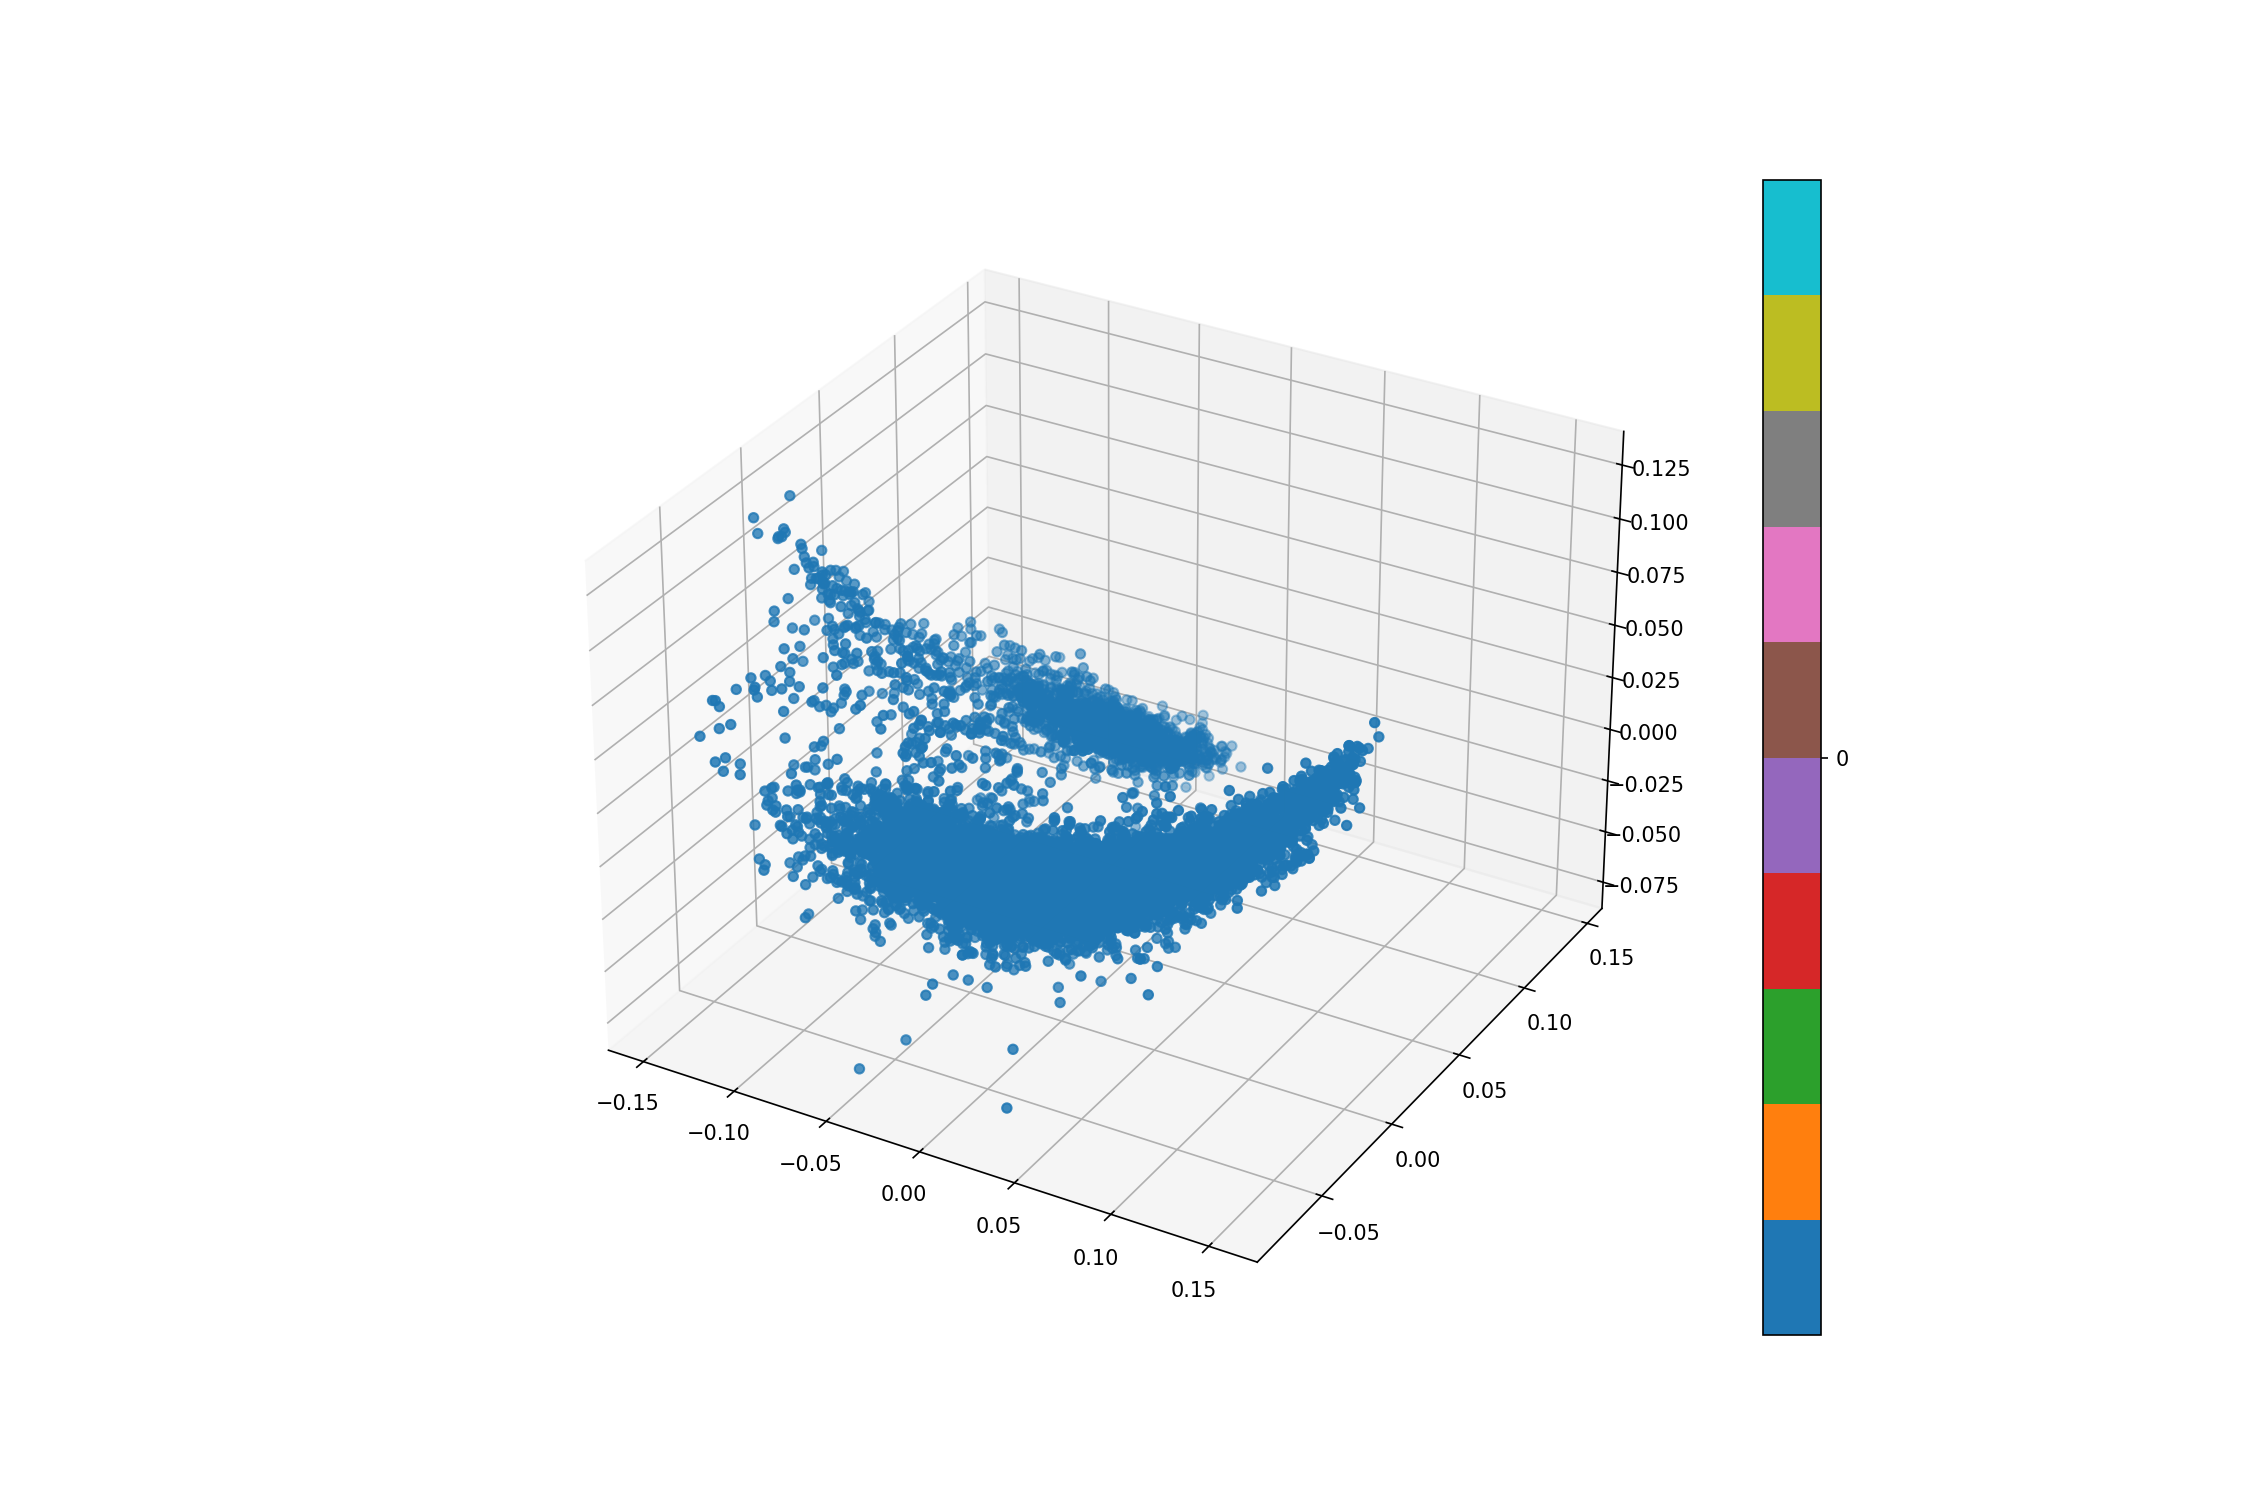

C:\Users\comin\AppData\Local\Temp\ipykernel_23536\3354104670.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(col)


In [21]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

model = DBSCAN(eps=20, min_samples=10)
y_predict = model.fit_predict(X)
print("DBSCAN purity", tot_purity(y_predict, y))

print("Number of outliers", (y_predict == -1).sum())
ids, counts = np.unique(y_predict, return_counts=True)
print(pd.DataFrame(counts.reshape(1, -1), columns=ids))

plot3d(X, labels=y_predict)

In [22]:
def make_scorer(metric):
    def scorer(estimator, X, y):
        y_pred = estimator.fit_predict(X)
        return metric(y_pred, y)
    return scorer

In [23]:
from sklearn.model_selection import GridSearchCV

params = {'eps': range(15,20), 'min_samples': range(1,5)}
cv = GridSearchCV(model, params, scoring=make_scorer(tot_purity), cv=3)
cv = cv.fit(X, y)

C:\Users\comin\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\comin\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\comin\miniconda3\Lib\site-packages\sklearn\cluster\_dbscan.py", line 366, in fit
    self._validate_params()
  File "C:\Users\comin\miniconda3\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\comin\miniconda3\Lib\site-pac

In [24]:
print(cv.best_params_)
print("CV score", tot_purity(cv.best_estimator_.fit_predict(X), y))

pd.DataFrame(cv.cv_results_)

{'eps': 15, 'min_samples': 1}


KeyboardInterrupt: 

### WIth the best parameters found with CV:

In [31]:
model = DBSCAN(eps=100, min_samples=100)
y_predict = model.fit_predict(X)
print("DBSCAN purity", tot_purity(y_predict, y))

print("Number of outliers", (y_predict == -1).sum())
ids, counts = np.unique(y_predict, return_counts=True)
print(pd.DataFrame(counts.reshape(1, -1), columns=ids))

#plot3d(X, labels=y_predict)


KeyboardInterrupt



# PCA

In [4]:
training = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
training = training.iloc[:, 1:]
test = test.iloc[:, 1:]

In [5]:
from sklearn.decomposition import PCA

# Define PCA with 3 components, this will transform 
pca = PCA(n_components=3)

X_prj = pca.fit_transform(training.iloc[:, 5:].drop("AGA", axis = 1))

X_prj.shape
# Why not normalize to mean = 0?
# For visualization we don't need to do it.
# I can try to normalize and see what happen.

(10422, 3)

Shape of X before passing to plot3d: (10422, 63)
Number of labels: 10422
Shape of X before reshaping: (10422, 63)
Number of labels: 10422
Shape of X after reshaping: (10422, 63)
Shape of X after PCA: (10422, 3)
Unique labels: ['arc' 'bct' 'inv' 'mam' 'phg' 'plm' 'pln' 'pri' 'rod' 'vrl' 'vrt']
Numeric labels: [9 2 1 ... 1 6 6]


<IPython.core.display.Javascript object>


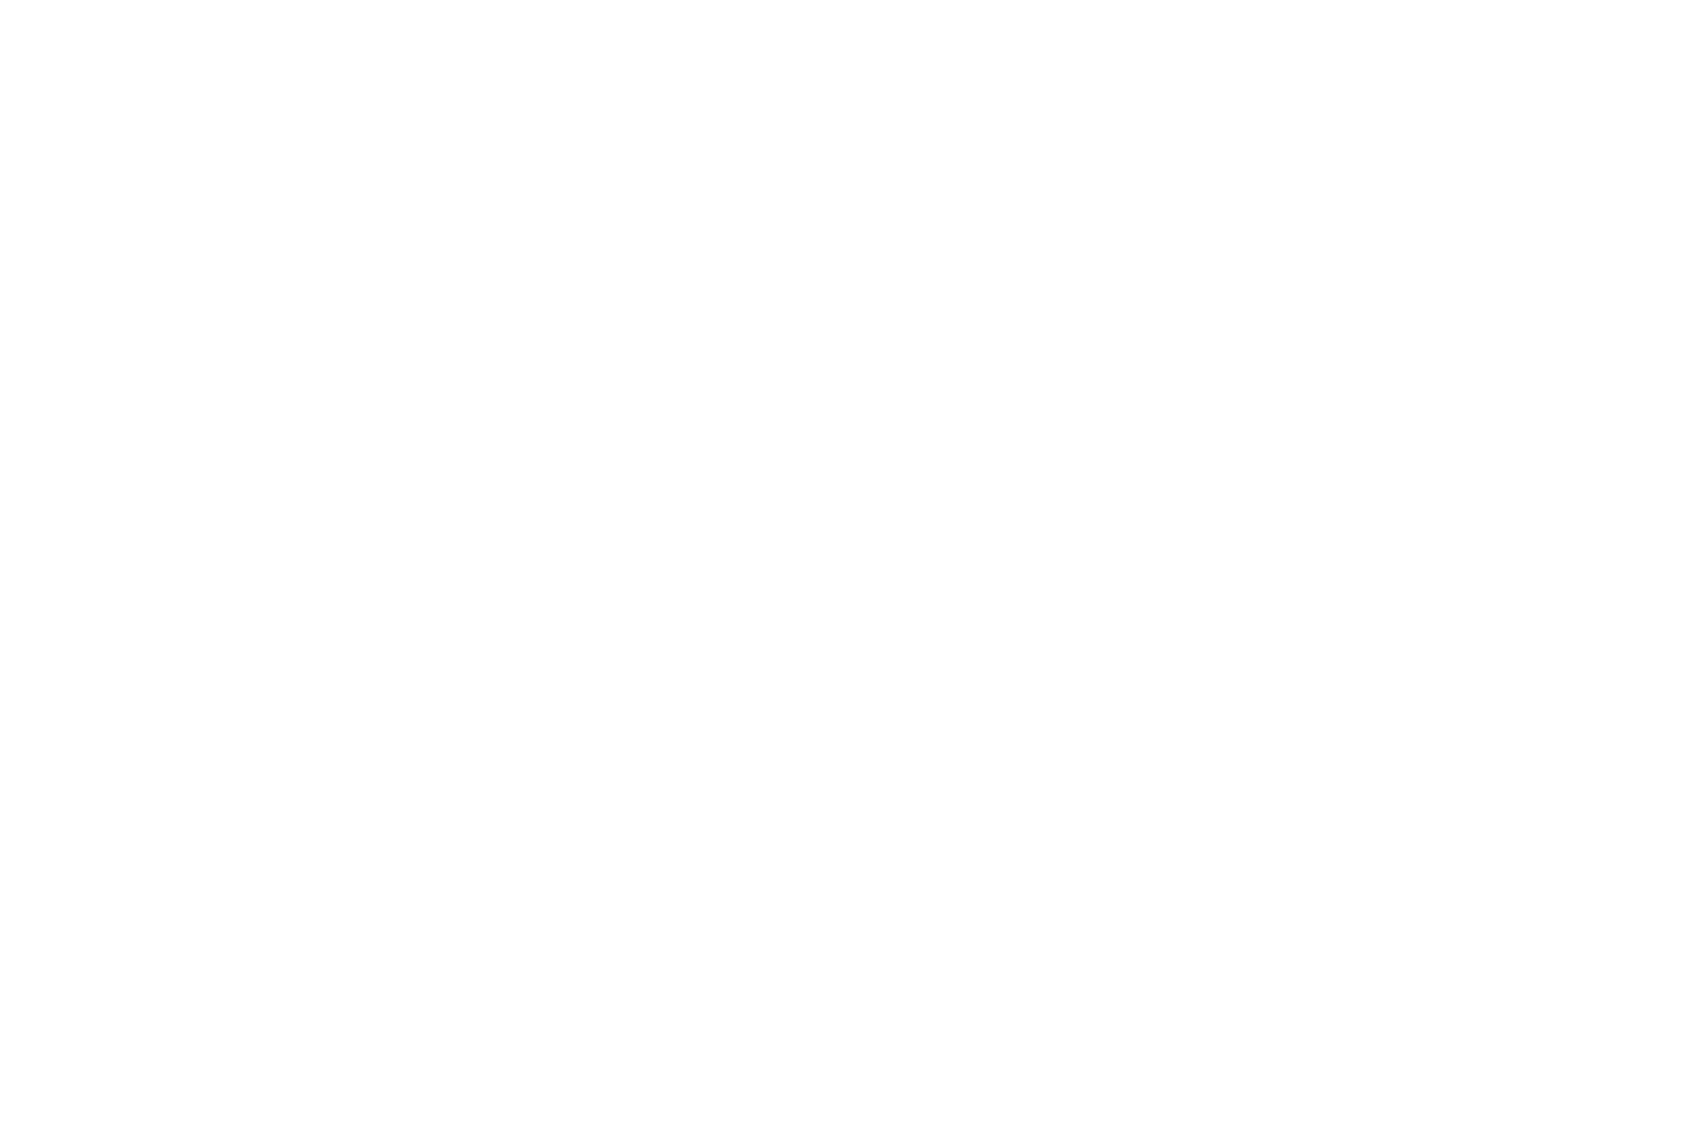

C:\Users\comin\AppData\Local\Temp\ipykernel_24640\223492279.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(col)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA

def plot3d(X, labels):
    %matplotlib notebook
    from mpl_toolkits.mplot3d import Axes3D
    
    # Check the shape of X and labels before proceeding
    print(f"Shape of X before reshaping: {X.shape}")
    print(f"Number of labels: {len(labels)}")
    
    # Ensure X is reshaped correctly
    X = X.reshape(X.shape[0], -1)
    print(f"Shape of X after reshaping: {X.shape}")
    
    # Reduce features dimensionality for visualization purposes
    pca = PCA(n_components=3)
    X = pca.fit_transform(X)
    print(f"Shape of X after PCA: {X.shape}")
    
    # Convert string labels to numeric labels
    unique_labels = np.unique(labels)
    label_to_num = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_to_num[label] for label in labels])
    
    print(f"Unique labels: {unique_labels}")
    print(f"Numeric labels: {numeric_labels}")
    
    nlabels = len(unique_labels)
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define color mappings
    col = ('tab10' if nlabels <= 10 else 
           ('tab20' if nlabels <= 20 else
            'hsv'))
    cmap = plt.cm.get_cmap(col)
    
    # Plot the 3D coordinates
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=numeric_labels, cmap=cmap)
    
    # Create a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(label_to_num[label] / (nlabels - 1)), markersize=10) for label in unique_labels]
    ax.legend(handles, unique_labels, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

# Assuming 'training' is a DataFrame
# Drop "AGA" column and convert to numpy array
X = training.iloc[:, 5:].drop("AGA", axis=1).to_numpy()

# Use a single column for labels (adjust as needed)
# Assuming the label column is "Label" (change to your actual label column name)
labels = training["Kingdom"]

print(f"Shape of X before passing to plot3d: {X.shape}")
print(f"Number of labels: {len(labels)}")

# Call the plot3d function
plot3d(X, labels)


Shape of X before passing to plot3d: (10422, 63)
Number of labels: 10422
Shape of X before reshaping: (10422, 63)
Number of labels: 10422
Shape of X after reshaping: (10422, 63)
Unique labels: ['arc' 'bct' 'inv' 'mam' 'phg' 'plm' 'pln' 'pri' 'rod' 'vrl' 'vrt']
Numeric labels: [9 2 1 ... 1 6 6]


<IPython.core.display.Javascript object>


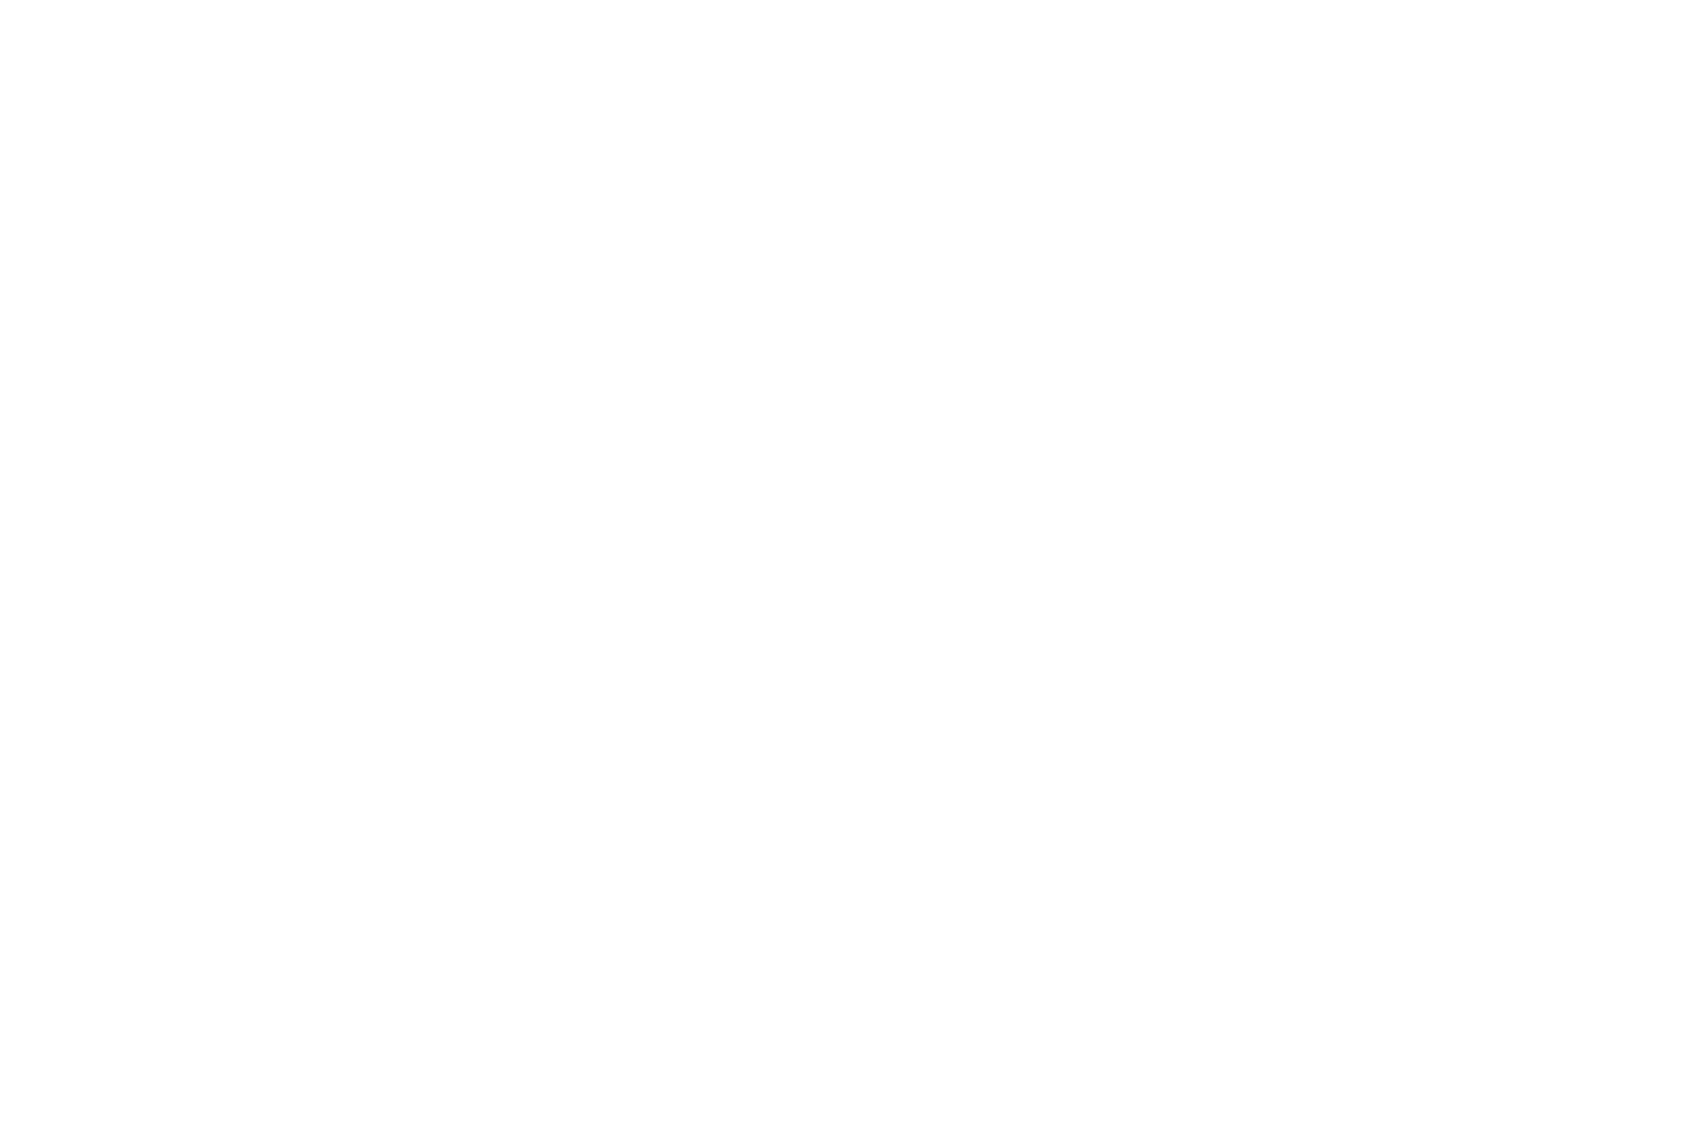

C:\Users\comin\AppData\Local\Temp\ipykernel_24640\2433534232.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(col)


In [7]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors

def plot3d(X, labels):
    %matplotlib notebook
    from mpl_toolkits.mplot3d import Axes3D

    # Check the shape of X and labels before proceeding
    print(f"Shape of X before reshaping: {X.shape}")
    print(f"Number of labels: {len(labels)}")

    # Ensure X is reshaped correctly
    X = X.reshape(X.shape[0], -1)
    print(f"Shape of X after reshaping: {X.shape}")

    # Reduce features dimensionality for visualization purposes
    tsne = TSNE(n_components=3)
    X = tsne.fit_transform(X)

    # Convert string labels to numeric labels
    unique_labels = np.unique(labels)
    label_to_num = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_to_num[label] for label in labels])

    print(f"Unique labels: {unique_labels}")
    print(f"Numeric labels: {numeric_labels}")

    nlabels = len(unique_labels)

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Define color mappings
    col = ('tab10' if nlabels <= 10 else 
           ('tab20' if nlabels <= 20 else
            'hsv'))
    cmap = plt.cm.get_cmap(col)

    # Plot the 3D coordinates
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=numeric_labels, cmap=cmap)

    # Create a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(label_to_num[label] / (nlabels - 1)), markersize=10) for label in unique_labels]
    ax.legend(handles, unique_labels, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

# Assuming 'training' is a DataFrame
# Drop "AGA" column and convert to numpy array
X = training.iloc[:, 5:].drop("AGA", axis=1).to_numpy()

# Use a single column for labels (adjust as needed)
# Assuming the label column is "Label" (change to your actual label column name)
labels = training["Kingdom"]

print(f"Shape of X before passing to plot3d: {X.shape}")
print(f"Number of labels: {len(labels)}")

# Call the plot3d function
plot3d(X, labels)
